In [40]:
import sys, time, argparse, re, gensim, math
import pandas as pd
from tqdm import tqdm
import pickle as pkl
import numpy as np
import faulthandler
import logging
from os.path import exists
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import plotly.graph_objects as go
from  sklearn.preprocessing import normalize
from scipy.spatial import distance
from itertools import combinations
from plotly.subplots import make_subplots

In [2]:
def read_file(input_path):
    logging.info('Opened: ' + input_path)
    with open(input_path, "rb") as f:
        input_obj = pkl.load(f)
        return input_obj

In [13]:
df_1700 = read_file('../data/1700/1700_all_top_descriptors_500.pickle').reset_index(drop=True)
df_1800 = read_file('../data/1800/1800_all_top_descriptors_500.pickle').reset_index(drop=True)
df_1900 = read_file('../data/1900/1900_all_top_descriptors_500.pickle').reset_index(drop=True)

In [14]:
df_1700['literary_period'] = '1700'
df_1800['literary_period'] = '1800'
df_1900['literary_period'] = '1900'

In [15]:
combined_periods = pd.concat([df_1700, df_1800])
combined_periods = pd.concat([combined_periods, df_1900])

In [16]:
sight_df = combined_periods.loc[combined_periods['modality'] == 'sight']
hear_df = combined_periods.loc[combined_periods['modality'] == 'hear']
touch_df = combined_periods.loc[combined_periods['modality'] == 'touch']
taste_df = combined_periods.loc[combined_periods['modality'] == 'taste']
smell_df = combined_periods.loc[combined_periods['modality'] == 'smell']

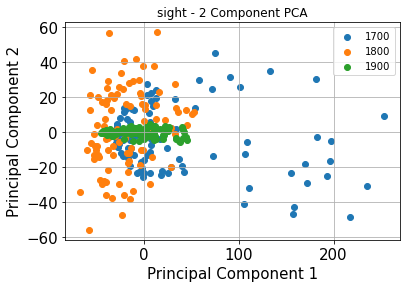

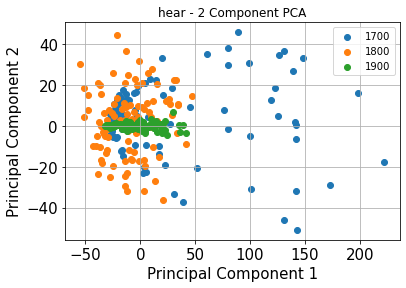

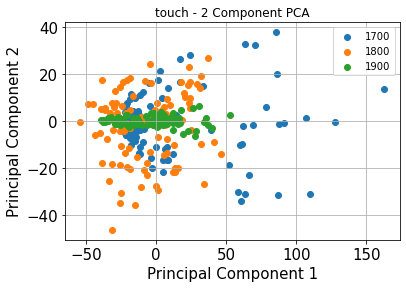

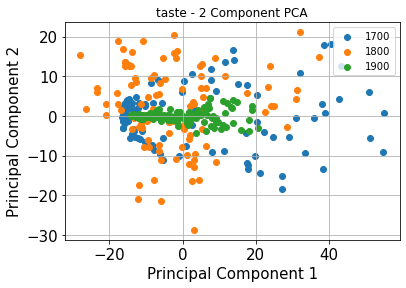

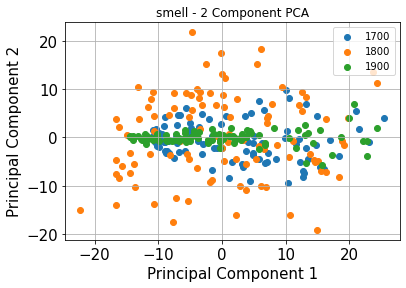

In [17]:
modality_dict = {'sight': sight_df, 'hear': hear_df, 'touch': touch_df, 'taste': taste_df, 'smell': smell_df}
k = 2

for modality, df in modality_dict.items():
    fig = px.scatter(
                df,
                color=df["literary_period"],
                color_discrete_map={'1700': '#1f77b4', '1800': '#2ca02c', '1900': '#d62728'},
                x=df['Principal Component 1'],
                y=df['Principal Component 2'],
                hover_data=df.columns[:-1 * k],
                custom_data=df.columns[:-1 * k],
                title= modality + " - " + str(k) + " Component PCA")
    fig.update_traces(marker=dict(size=12,))
    fig.write_html('../visuals/' + modality + '_pca_plot.html')
    fig.show()

    fig, ax = plt.subplots()
    for i,d in df.groupby('literary_period'):
        ax.scatter(d['Principal Component 1'], d['Principal Component 2'], label=i)
    plt.title(modality + " - " + str(k) + " Component PCA")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig('../visuals/' + modality + '_pca_plot.pdf')

### 2-Sense Mixtures: Average Pairwise Distance between Sense Pairs AND  Sensory Descriptors within a 30-radius Area

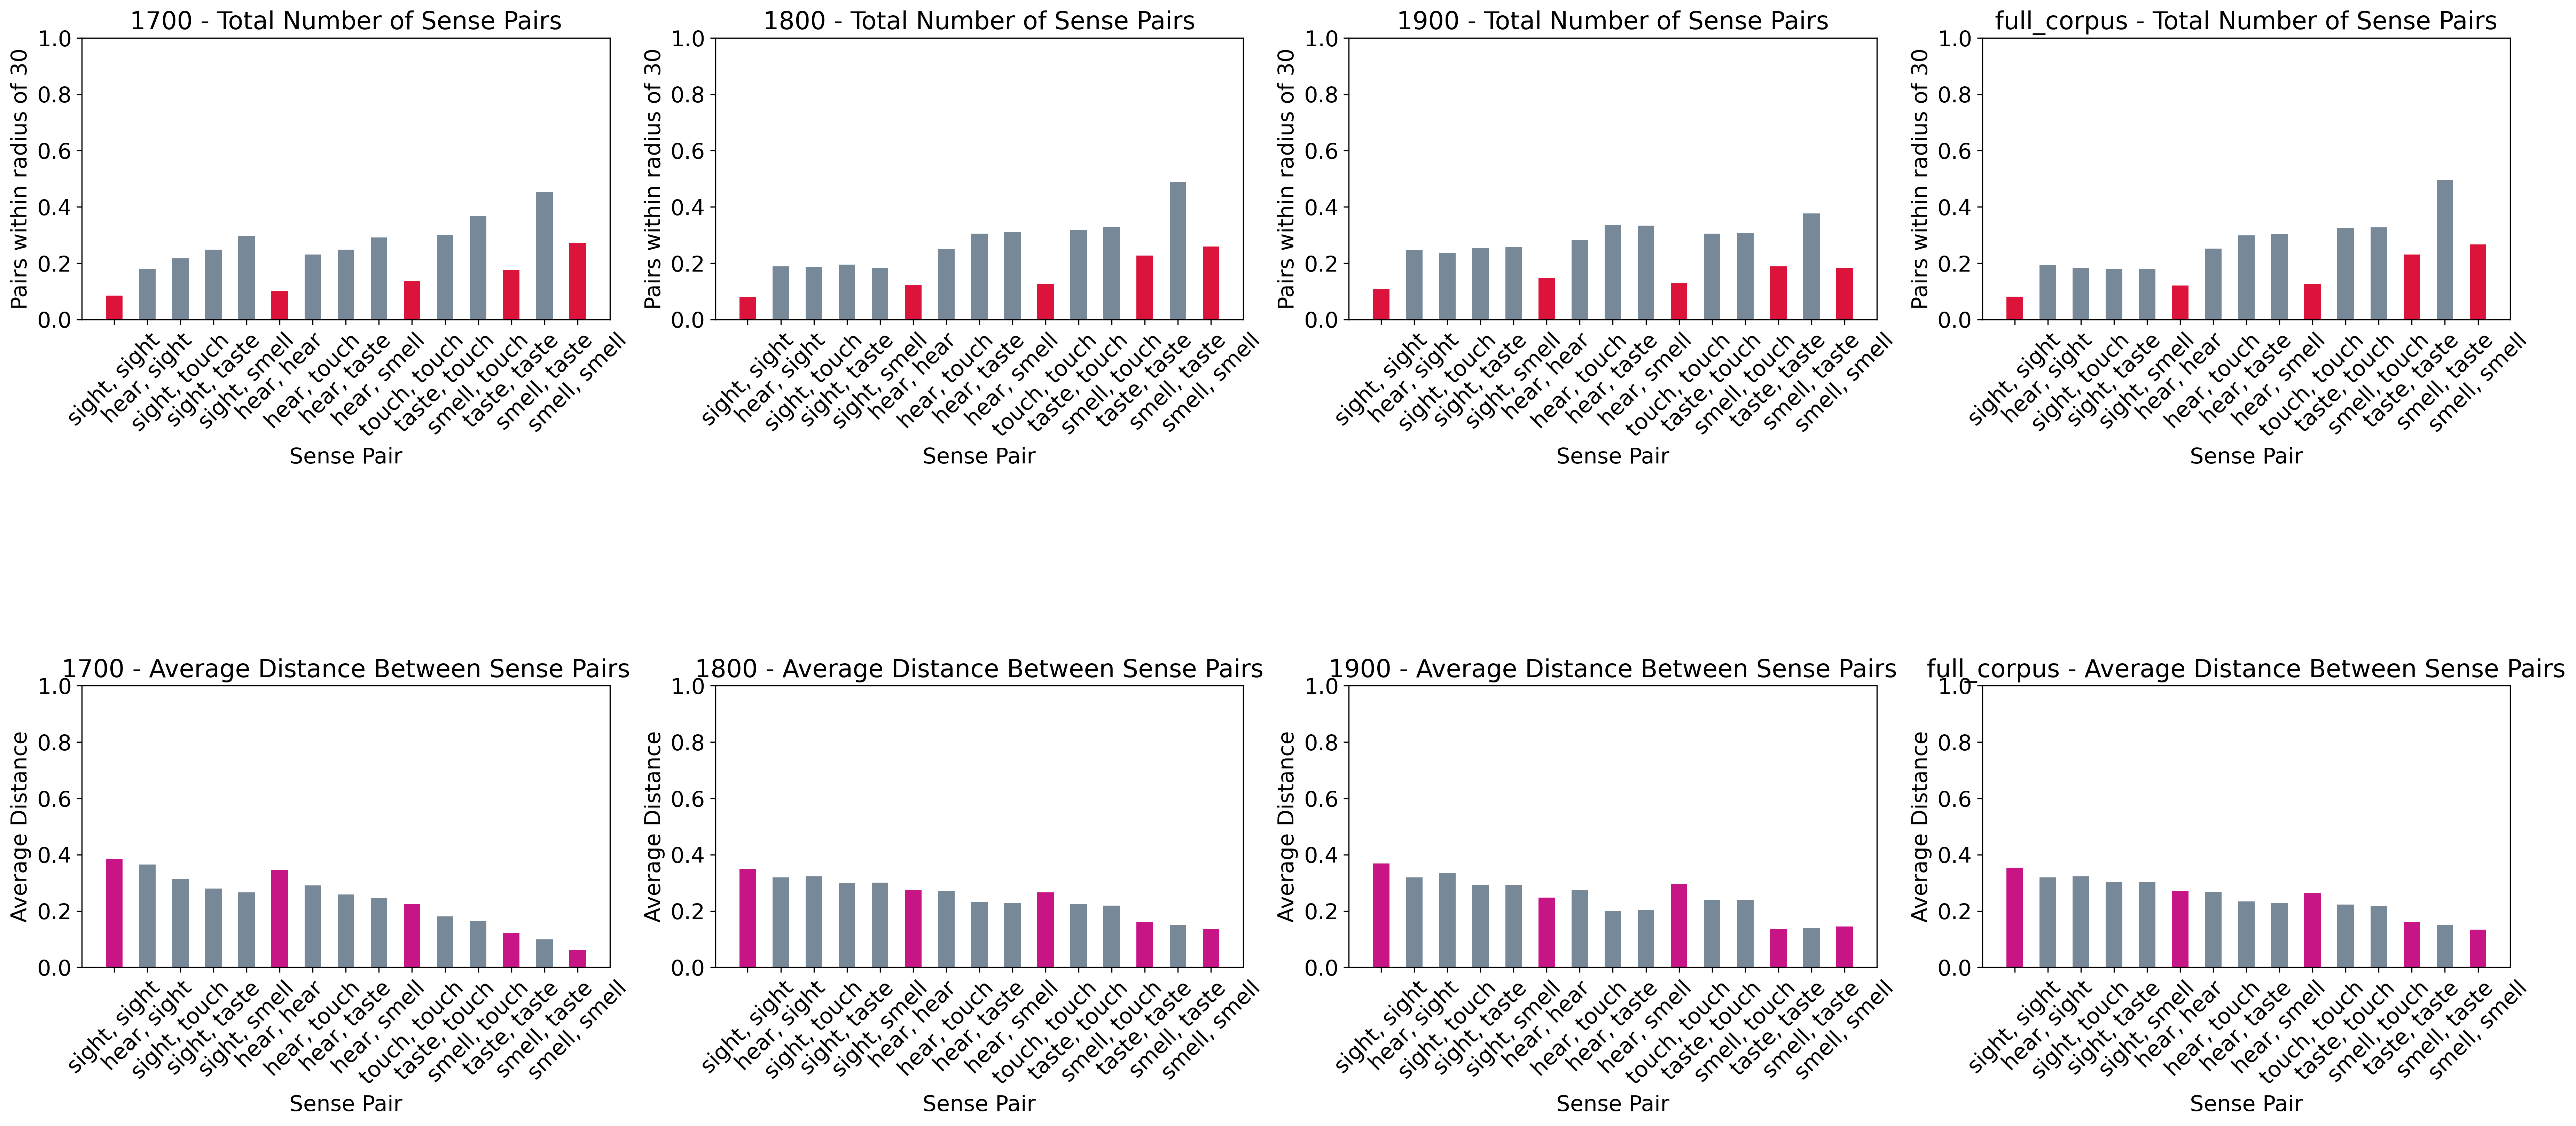

In [18]:
SENSES = ['sight', 'hear', 'touch', 'taste', 'smell']
radius = 30
literary_periods = ['1700', '1800', '1900', 'full_corpus']

plt.figure(figsize=(30,20), dpi = 300)
num_a = 1
num_b = 5
num_c = 9 
plt.tight_layout()

def format_key(pair):
    return ", ".join(sorted(pair))


def avg(value):
    ret = 0 if value[1] == 0 else value[0]/value[1]
    return ret

for period in literary_periods:

    senses_and_freqs = {format_key((SENSES[i],SENSES[j])):0 for i in range(len(SENSES)) for j in range(i, len(SENSES))}
    senses_and_avgs = {format_key((SENSES[i],SENSES[j])):[0,0] for i in range(len(SENSES)) for j in range(i, len(SENSES))}

    all_top_descriptors = read_file('../data/' + period + '/' + period + '_all_top_descriptors_500.pickle')
    
    points = []
    points_with_sense = []
    for index, row in all_top_descriptors.iterrows():
        points.append([row['Principal Component 1'], row['Principal Component 2']])
        points_with_sense.append([[row['Principal Component 1'], row['Principal Component 2']], row['modality']])
        
    euclidean_dists = euclidean_distances(points, points)
    
    total = 0
    same_sense = 0
    visited_points = []
    for i, row in enumerate(euclidean_dists):
        for j, distance in enumerate(row):
            if i == j or sorted((i,j)) in visited_points: continue
            visited_points.append(sorted((i,j)))
            sense_i = points_with_sense[i][1]
            sense_j = points_with_sense[j][1]
            pair = format_key([sense_i, sense_j])
            senses_and_avgs[pair][0] += distance
            senses_and_avgs[pair][1] += 1
            if distance > radius: continue
            senses_and_freqs[pair] += 1
            if sense_i == sense_j:
                same_sense += 1
            total += 1
    senses_and_avgs = {pair:avg(value) for pair, value in senses_and_avgs.items()}
    
    colors1 = ['lightslategray',] * len(senses_and_freqs)
    same_indices = [i for i, pair in enumerate(senses_and_freqs) if pair.split(", ")[0] == pair.split(", ")[1]]
    for i in same_indices:
        colors1[i] = "crimson"
    layout = go.Layout(
        title = period + " - Total Number of Sense Pairs",
        xaxis = dict(title="Sense Pair"),
        yaxis = dict(title="Pairs within radius of " + str(radius))
    )

    fig = go.Figure(layout=layout,
                    data=[go.Bar(x = list(senses_and_freqs.keys()),
                            y = normalize([list(senses_and_freqs.values())])[0],
                    marker_color=colors1)])
    fig.update_yaxes(range=[0, 1])
    fig.show()
    fig.write_html('../visuals/' + period + '/' + period + '_total_sense_pairs_500.html')
    
    
    layout = go.Layout(
            title = period + " - Average Distance Between Sense Pairs",
            xaxis = dict(title="Sense Pair"),
            yaxis = dict(title="Average Distance")
        )
    colors2 = ['lightslategray',] * len(senses_and_avgs)
    same_indices = [i for i, pair in enumerate(senses_and_avgs) if pair.split(", ")[0] == pair.split(", ")[1]]
    for i in same_indices:
        colors2[i] = "mediumvioletred"
    fig = go.Figure(layout=layout,
                    data=[go.Bar(x = list(senses_and_avgs.keys()),
                            y = normalize([list(senses_and_avgs.values())])[0],
                    marker_color=colors2)])
    fig.update_yaxes(range=[0, 1])
    fig.show()
    fig.write_html('../visuals/' + period + '/' + period + '_average_distance_between_sense_pairs_500.html')
    
    plt.subplot(3, 4, num_a)
    num_a += 1
    plt.bar(list(senses_and_freqs.keys()), normalize([list(senses_and_freqs.values())])[0], label=list(senses_and_freqs.keys()), width=0.5, color = colors1)
    plt.title(period + " - Total Number of Sense Pairs", fontsize=17)
    plt.xlabel('Sense Pair')
    plt.ylabel("Pairs within radius of " + str(radius))
    plt.rc('axes', labelsize=15)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xticks(rotation = 45)
    plt.ylim(0, 1)

    
    plt.subplot(3, 4, num_b)
    num_b += 1
    plt.bar(list(senses_and_avgs.keys()), normalize([list(senses_and_avgs.values())])[0], label=list(senses_and_avgs.keys()), width=0.5, color = colors2)
    plt.title(period + " - Average Distance Between Sense Pairs", fontsize=17)
    plt.xlabel('Sense Pair')
    plt.ylabel("Average Distance")
    plt.rc('axes', labelsize=15)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xticks(rotation = 45) 
    plt.ylim(0, 1)

    
plt.subplots_adjust(hspace=1.3)
plt.savefig('../visuals/all_sense_pairs.jpeg', bbox_inches="tight", dpi=300, transparent=False,)    
plt.show()

### 3-Sense Mixtures: Average Pairwise Distance between Sense Pairs AND  Sensory Descriptors within a 30-radius Area

In [4]:
SENSES = ['sight', 'hear', 'touch', 'taste', 'smell']
radius = 30
literary_periods = ['1700', '1800', '1900', 'full_corpus']

plt.figure(figsize=(35,20), dpi = 300)
num_a = 1
num_b = 5
num_c = 9 
plt.tight_layout()


def format_key(triplet):
    return ", ".join(sorted(triplet))

def avg(value):
    ret = 0 if value[1] == 0 else value[0]/value[1]
    return ret
    
for period in literary_periods:
    all_top_descriptors = read_file('../data/' + period + '/' + period + '_all_top_descriptors_500.pickle')
    
    senses_and_freqs = {format_key((SENSES[i],SENSES[j],SENSES[k])):0 for i in range(len(SENSES)) for j in range(i, len(SENSES)) for k in range(j, len(SENSES))}
    senses_and_avgs = {format_key((SENSES[i],SENSES[j],SENSES[k])):[0,0] for i in range(len(SENSES)) for j in range(i, len(SENSES)) for k in range(j, len(SENSES))}
    
    points = []
    points_with_sense = []
    for index, row in all_top_descriptors.iterrows():
        points.append([row['Principal Component 1'], row['Principal Component 2']])
        points_with_sense.append([[row['Principal Component 1'], row['Principal Component 2']], row['modality']])
        
    euclidean_dists = euclidean_distances(points, points)
    
    two_points = []
    visited_points = []
    for i, row in enumerate(euclidean_dists):
        for j, distance in enumerate(row):
            if i == j or sorted((i,j)) in visited_points: continue
            visited_points.append(sorted((i,j)))
            sense_i = points_with_sense[i][1]
            sense_j = points_with_sense[j][1]
            two_points.append([(i,j), distance, [sense_i, sense_j]])
                
    visited_points = []
    for value in two_points:
        pair, distance, modalities = value
        i = pair[0]
        j = pair[1]
        row = euclidean_dists[i]
        for k, distance2 in enumerate(row):
            if i == k or j == k or sorted((i,j, k)) in visited_points: continue
            visited_points.append(sorted((i,j,k)))
            sense_k = points_with_sense[k][1]
            distance3 = euclidean_dists[j][k]
            triplet = format_key([sense_i, sense_j, sense_k])
            senses_and_avgs[triplet][0] += sum([distance, distance2, distance3])
            senses_and_avgs[triplet][1] += 1
            if distance1 > radius or distance2 > radius: continue
            senses_and_freqs[triplet] += 1
                
    senses_and_avgs = {pair:avg(value) for pair, value in senses_and_avgs.items()}
    
    colors1 = ['lightslategray',] * len(senses_and_freqs)
    same_indices = [i for i, pair in enumerate(senses_and_freqs) if pair.split(", ")[0] == pair.split(", ")[1] and pair.split(", ")[1] == pair.split(", ")[2]]
    for i in same_indices:
        colors1[i] = "crimson"
    layout = go.Layout(
        title = period + " - Total Number of Sense Triplets",
        xaxis = dict(title="Sense Triplets"),
        yaxis = dict(title="Triplets within radius of " + str(radius))
    )

    fig = go.Figure(layout=layout,
                    data=[go.Bar(x = list(senses_and_freqs.keys()),
                            y = normalize([list(senses_and_freqs.values())])[0],
                    marker_color=colors1)])

    fig.update_yaxes(range=[0, 1])
    fig.show()
    fig.write_html('../visuals/' + period + '/' + period + '_total_sense_triplets_500.html')

    layout = go.Layout(
            title = period + " - Average Distance Between Sense Triplets",
            xaxis = dict(title="Sense Triplets"),
            yaxis = dict(title="Average Distance")
        )
    colors2 = ['lightslategray',] * len(senses_and_avgs)
    same_indices = [i for i, pair in enumerate(senses_and_avgs) if pair.split(", ")[0] == pair.split(", ")[1] and pair.split(", ")[1] == pair.split(", ")[2]]
    for i in same_indices:
        colors2[i] = "mediumvioletred"
    fig = go.Figure(layout=layout,
                    data=[go.Bar(x = list(senses_and_avgs.keys()),
                            y = normalize([list(senses_and_avgs.values())])[0],
                    marker_color=colors2)])
    fig.update_yaxes(range=[0, 1])
    fig.show()
    fig.write_html('../visuals/' + period + '/' + period + '_average_distance_between_sense_triplets_500.html')
    
    plt.subplot(3, 4, num_a)
    num_a += 1
    plt.bar(list(senses_and_freqs.keys()), normalize([list(senses_and_freqs.values())])[0], label=list(senses_and_freqs.keys()), width=0.5, color = colors1)
    plt.title(period + " - Total Number of Sense Triplets", fontsize=17)
    plt.xlabel('Sense Triplets')
    plt.ylabel("Triplets within radius of " + str(radius))
    plt.rc('axes', labelsize=15)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xticks(rotation = 90)
    plt.ylim(0, 1)

    
    plt.subplot(3, 4, num_b)
    num_b += 1
    plt.bar(list(senses_and_avgs.keys()), normalize([list(senses_and_avgs.values())])[0], label=list(senses_and_avgs.keys()), width=0.5, color = colors2)
    plt.title(period + " - Average Distance Between Sense Triplets", fontsize=17)
    plt.xlabel('Sense Triplets')
    plt.ylabel("Average Distance")
    plt.rc('axes', labelsize=15)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xticks(rotation = 90) 
    plt.ylim(0, 1)

    
plt.subplots_adjust(hspace=1.3)
plt.savefig('../visuals/all_sense_triplets.jpeg', bbox_inches="tight", dpi=300, transparent=False,)    
plt.show()
    

KeyboardInterrupt: 

<Figure size 10500x6000 with 0 Axes>

### Ranked Descriptors

In [40]:
for period in literary_periods: 
    all_top_descriptors = read_file('../data/' + period + '/' + period + '_all_top_descriptors_500.pickle')
    filtered_descriptors = read_file('../data/' + period + '/filtered_descriptors.pickle')
    context_windows = read_file('../data/' + period + '/context_windows.pickle')
    
    all_top_descriptors = all_top_descriptors.reset_index(drop = True)
    all_top_descriptors['descriptor'] = all_top_descriptors['word'].str[0]
    all_top_descriptors['POS'] = all_top_descriptors['word'].str[1]
    senses = [sense for sense in set(all_top_descriptors["modality"].values)]
    ranked = pd.DataFrame(columns=["descriptor", "POS"] + senses + ['total'])
    ranked.loc[:,'descriptor'] = all_top_descriptors['descriptor']
    ranked.loc[:,'POS'] = all_top_descriptors["POS"]
    ranked = ranked.drop_duplicates().fillna(0).reset_index(drop=True)
    for index, row in all_top_descriptors.iterrows():
        # get row of matching descriptor
        ranked_row = ranked.loc[(ranked['descriptor'] == row['descriptor']) & (ranked['POS'] == row['POS'])]
        ranked_idx = ranked_row.index
        ranked.at[ranked_idx[0], row["modality"]] = filtered_descriptors[row['modality']][row['word']]

    # Calculate the total frequency for each descriptor
    for sense in senses:
        ranked["total"] += ranked[sense]

    ranked = ranked.sort_values("total", ascending=False)

    # Remove all the descriptors that show no overlap of senses
    one_sense_only = ranked[(ranked == 0).sum(1) >= 4].index
    ranked = ranked.drop(one_sense_only)
    words = ranked["descriptor"].values
    n = min(20, len(words))
    data = []
    for label in SENSES:
        try:
            data.append(go.Bar(name=label, x=words[:n], y=ranked[label][:n].values/len(context_windows[label])))
        except KeyError:
            continue

    layout = go.Layout(
        title = period + "- Descriptor Sense Overlap",
        xaxis = dict(title="Top " + str(n) + " Descriptors"),
        yaxis = dict(title="Frequency")
    )
    fig = go.Figure(layout=layout, data=data)
    fig.update_layout(barmode='stack')
    fig.show()

    fig.write_html('../visuals/' + period + '/' + period + '_top_descriptors_overlap_500.html')
    
#     plt.subplot(3, 4, num_c)
#     num_c += 1
#     for label in SENSES:
#         plt.bar(words[:n], ranked[label][:n].values/len(context_windows[label]), label=label)
#     plt.title(period + "- Descriptor Sense Overlap", fontsize=17)
#     plt.xlabel("Top " + str(n) + " Descriptors")
#     plt.ylabel("Frequency")
#     plt.rc('axes', labelsize=15)
#     plt.rc('xtick', labelsize=15)
#     plt.rc('ytick', labelsize=15)
#     plt.xticks(rotation = 45) 
    
    


     descriptor   POS  sight  hear  smell  touch  taste  total
0          dark   ADV      5     0      0      0      0      0
1    submissive   ADJ      0    10      0      0      0      0
2           din  NOUN      0     6      0      0      0      0
3        psalms  NOUN      0     8      0      0      0      0
4        shouts  NOUN      0    17      0      0      0      0
..          ...   ...    ...   ...    ...    ...    ...    ...
495         sat  VERB      0     0      6      0      0      0
496       uncle  NOUN      0     0      5      0      0      0
497       found  VERB      0     0      8      0      0      0
498      nature  NOUN      0     0      5      0      0      0
499       water  NOUN      0     0      7      0      0      0

[500 rows x 8 columns]


     descriptor   POS  sight  hear  smell  touch  taste  total
0    unseeingly   ADV     32     0      0      0      0      0
1       droning  VERB      0    45      0      0      0      0
2     contralto   ADJ      0    53      0      0      0      0
3        bulged  VERB     39     0      0      0      0      0
4     quavering  NOUN      0    37      0      0      0      0
..          ...   ...    ...   ...    ...    ...    ...    ...
495     flowers  NOUN      0     0    446      0      0      0
496      column  NOUN      0     0     86      0      0      0
497        pine   ADJ      0     0     40      0      0      0
498       lungs  NOUN      0     0     45      0      0      0
499        soap  NOUN      0     0     46      0      0      0

[500 rows x 8 columns]


      descriptor   POS  sight  hear  smell  touch  taste  total
0         trippy  NOUN      2     0      0      0      0      0
1        balance  NOUN      0     0      0      2      0      0
2       showered  VERB      0     0      0      2      0      0
3         second   ADJ      0     0      0      2      0      0
4    marvelously   ADV      0     0      0      2      0      0
..           ...   ...    ...   ...    ...    ...    ...    ...
490      strange   ADJ      0     0      0      0      2      0
491         long   ADV      0     0      0      0      3      0
492         deep   ADJ      0     0      0      0      2      0
493        trees  NOUN      0     0      0      0      2      0
494       tongue  NOUN      0     0      0      0      2      0

[495 rows x 8 columns]


    descriptor   POS  sight  hear  smell  touch  taste  total
0    twinkling   ADJ     53     0      0      0      0      0
1      twinkle  VERB     31     0      0      0      0      0
2    contralto   ADJ      0    53      0      0      0      0
3      droning  VERB      0    46      0      0      0      0
4       bulged  VERB     39     0      0      0      0      0
..         ...   ...    ...   ...    ...    ...    ...    ...
495      roman   ADJ      0     0     67      0      0      0
496     clouds  NOUN      0     0    281      0      0      0
497     curved  VERB      0     0     33      0      0      0
498      dense   ADJ      0     0     82      0      0      0
499     column  NOUN      0     0     92      0      0      0

[500 rows x 8 columns]


## Sensory Imbalance Distribution

In [63]:
literary_periods = ['1700', '1800', '1900', 'full_corpus']
SENSES = ['sight', 'hear', 'touch', 'taste', 'smell']
context_window_distribution = pd.DataFrame(columns = ['Period, Sense', 'period', 'modality', 'size'])
for period in literary_periods: 
    context_windows = read_file('../data/' + period + '/context_windows.pickle')
    for sense in SENSES:
        context_window_distribution = context_window_distribution.append({'Period, Sense':str(period) + ", " + sense,
                                                                          'period':period,
                                                                          'modality' : sense,
                                                                          'size' : len(context_windows[sense])} , ignore_index = True)
context_window_distribution['normalized_size'] = normalize([list(context_window_distribution['size'])])[0]
context_window_distribution.head()

,"Period, Sense",period,modality,size,normalized_size
0,"1700, sight",1700,sight,30751,0.023819
1,"1700, hear",1700,hear,21586,0.016720
2,"1700, touch",1700,touch,12624,0.009778
3,"1700, taste",1700,taste,4334,0.003357
4,"1700, smell",1700,smell,1843,0.001428


In [70]:
fig = px.bar(context_window_distribution, title = "Size of Context Windows for Each Period", x="Period, Sense", y = "size", color = "modality", color_discrete_map={'sight': '#1f77b4', 'hear': '#2ca02c', 'taste': '#d62728', 'smell': '#ff7f0e', 'touch': '#9467bd'})
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray': context_window_distribution["Period, Sense"]})
fig.write_html('../visuals/size_of_context_windows.html')
fig.show()

In [71]:
fig = px.bar(context_window_distribution, title = "Size of Context Windows for Each Period", x="Period, Sense", y = "normalized_size", color = "modality", color_discrete_map={'sight': '#1f77b4', 'hear': '#2ca02c', 'taste': '#d62728', 'smell': '#ff7f0e', 'touch': '#9467bd'})
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray': context_window_distribution["Period, Sense"]})
fig.write_html('../visuals/size_of_context_windows_normalized.html')
fig.show()

In [69]:
fig = make_subplots(rows=1, cols=4, subplot_titles=("1700", "1800", "1900", "Full Corpus"))

fig.add_trace(go.Bar(x=context_window_distribution[context_window_distribution['period'] == '1700']['modality'], 
                     y=context_window_distribution[context_window_distribution['period'] == '1700']['size']),
                     row=1, 
                     col=1)

fig.add_trace(go.Bar(x=context_window_distribution[context_window_distribution['period'] == '1800']['modality'], 
                     y=context_window_distribution[context_window_distribution['period'] == '1800']['size']),
                     row=1, 
                     col=2)

fig.add_trace(go.Bar(x=context_window_distribution[context_window_distribution['period'] == '1900']['modality'], 
                     y=context_window_distribution[context_window_distribution['period'] == '1900']['size']),
                     row=1, 
                     col=3)

fig.add_trace(go.Bar(x=context_window_distribution[context_window_distribution['period'] == 'full_corpus']['modality'], 
                     y=context_window_distribution[context_window_distribution['period'] == 'full_corpus']['size']),
                     row=1, 
                     col=4)

fig.update_layout(height=600, width=1300, title_text="Sense Distribution")

fig.show()